# Sweet Vs. Savory

## Setup ##

In [1]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
np.random.seed(42)
from tqdm import tqdm
import os
import tensorflow as tf
tf.random.set_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Transforms and Data Download ##

In [2]:
# Define data augmentation and preprocessing
import cv2
from torchvision import transforms
from PIL import Image

class HistogramEqualization:
    def __call__(self, img):
        # Convert PIL image to NumPy array
        image = np.array(img)
        if len(image.shape) == 3:  # Color image (3 channels)
            # Split the image into its color channels
            channels = cv2.split(image)
            # Equalize histogram for each channel
            equalized_channels = [cv2.equalizeHist(channel) for channel in channels]
            # Merge the equalized channels back
            equalized_image = cv2.merge(equalized_channels)
        else:  # Grayscale image (1 channel)
            equalized_image = cv2.equalizeHist(image)

            # Convert grayscale image to 3-channel RGB by repeating the single channel
            equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2RGB)

        # Convert back to PIL image
        return Image.fromarray(equalized_image)

# Define data augmentation pipeline
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),           # Center crop to 224x224
    HistogramEqualization(),  # Custom histogram equalization transform
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # From ImageNet
])

In [3]:
root = './food101'
food101 = datasets.Food101(root=root, download=True, transform=data_transforms)

100%|██████████| 5.00G/5.00G [02:38<00:00, 31.4MB/s]


Extracting ./food101/food-101.tar.gz to ./food101


### Classes ###

In [4]:
sweet = ['apple_pie', 'baklava', 'beignets', 'bread_pudding', 'cannoli', 'carrot_cake',
         'cheesecake', 'chocolate_cake', 'chocolate_mousse', 'churros', 'creme_brulee',
         'cup_cakes', 'donuts', 'french_toast', 'frozen_yogurt', 'macarons',
         'ice_cream', 'pancakes', 'panna_cotta', 'red_velvet_cake', 'strawberry_shortcake',
         'tiramisu', 'waffles'
         ] # 23 classses

## Balanced Loading of Sweet and savory classes ##
Note: Change N accordingly. N suggested = 46000

In [5]:
from torch.utils.data import Dataset
from collections import defaultdict
import random
random.seed(42)

# Define the list of sweet and savory classes
sweet_classes = sweet

N = 46000  # Adjust this value based on your dataset size
BATCH_SIZE = 64 # Adjust batch size of all data loaders

# Define the dataset class
class BalancedSweetSavoryDataset(Dataset):
    def __init__(self, dataset, sweet_classes, savory_classes, N):
        self.dataset = dataset
        self.sweet_classes = sweet_classes
        self.savory_classes = savory_classes
        self.N = N

        # Calculate the number of images to sample from each class
        self.sweet_images_per_category = (N // 2) // len(sweet_classes)
        self.savory_images_per_category = (N // 2) // len(savory_classes)
        if (self.sweet_images_per_category > 1000) | (self.savory_images_per_category > 1000):
            print("Max capacity reached. Sampling 1000 for each")
            self.sweet_images_per_category = 1000
            self.savory_images_per_category = (N - (1000 * len(sweet_classes))) // 78

        print(f"{self.sweet_images_per_category} images per sweet class.  Number of sweet classes: {len(sweet_classes)}. ~{N // 2} sweet images")
        print(f"{self.savory_images_per_category} images per savory class.  Number of savory classes: {len(savory_classes)}. ~{N // 2} savory images\n")

        # Sample images from the sweet and savory classes
        self.sweet_images = self._sample_images_from_classes(self.sweet_classes, self.sweet_images_per_category, 1)
        print("--------------------------------------------------Sweet classes done")
        self.savory_images = self._sample_images_from_classes(self.savory_classes, self.savory_images_per_category, 0)

        # Combine the sampled images
        self.final_images = self.sweet_images + self.savory_images

    def _sample_images_from_classes(self, class_list, images_per_category, label):
        selected_images = []
        for class_name in class_list:
            print(f"Labelling and sampling from {class_name}")
            # Get all indices for the images in the current class
            class_dir = os.path.join(dir, class_name)
            class_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

            # Shuffle and then select the required number of images
            random.shuffle(class_images)
            for img_path in class_images[:images_per_category]:
                image = Image.open(img_path)  # Open the image with PIL
                # Apply transformations, including conversion to tensor
                image = self.dataset.transform(image)  # This applies ToTensor() and other transforms
                selected_images.append((image, label))

        return selected_images

    def __len__(self):
        return len(self.final_images)

    def __getitem__(self, idx):
        image, label = self.final_images[idx]
        return image, label

# Define savory classes (all classes in food101 except sweet classes)
savory_classes = [cls for cls in food101.classes if cls not in sweet_classes]

dir = "/content/food101/food-101/images"

# Initialize the dataset with N total images
balanced_dataset = BalancedSweetSavoryDataset(food101, sweet_classes, savory_classes, N)
dataloader = DataLoader(balanced_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

1000 images per sweet class.  Number of sweet classes: 23. ~23000 sweet images
294 images per savory class.  Number of savory classes: 78. ~23000 savory images

Labelling and sampling from apple_pie
Labelling and sampling from baklava
Labelling and sampling from beignets
Labelling and sampling from bread_pudding
Labelling and sampling from cannoli
Labelling and sampling from carrot_cake
Labelling and sampling from cheesecake
Labelling and sampling from chocolate_cake
Labelling and sampling from chocolate_mousse
Labelling and sampling from churros
Labelling and sampling from creme_brulee
Labelling and sampling from cup_cakes
Labelling and sampling from donuts
Labelling and sampling from french_toast
Labelling and sampling from frozen_yogurt
Labelling and sampling from macarons
Labelling and sampling from ice_cream
Labelling and sampling from pancakes
Labelling and sampling from panna_cotta
Labelling and sampling from red_velvet_cake
Labelling and sampling from strawberry_shortcake
Label

## Data Statistics ##

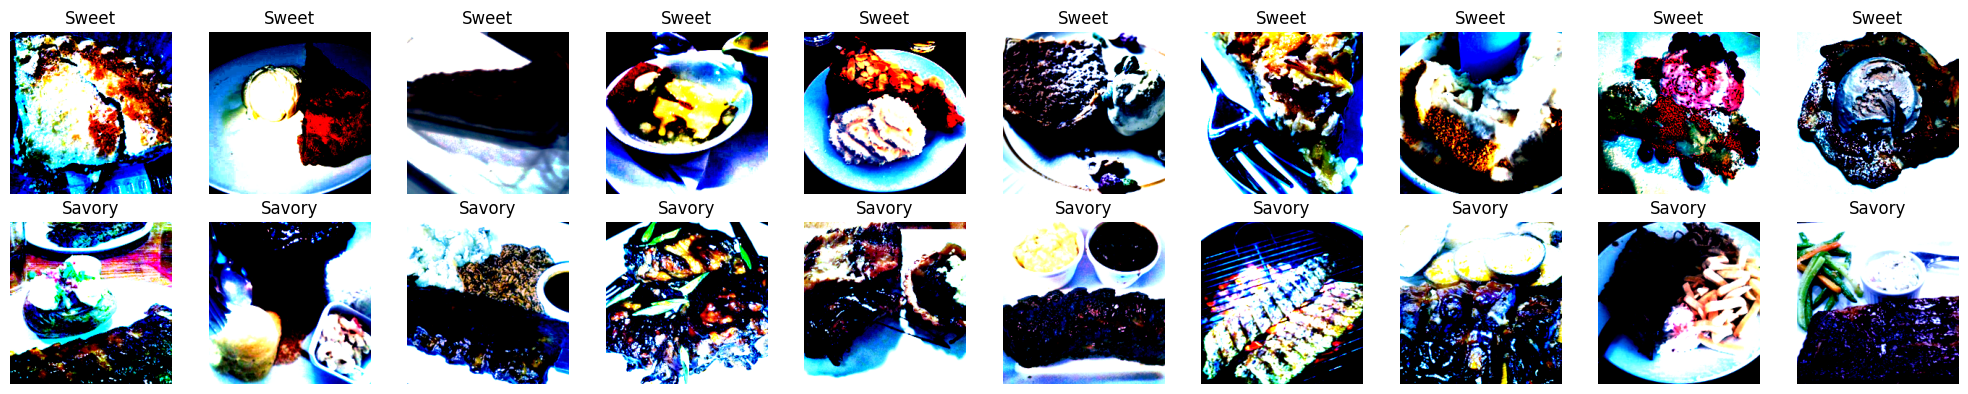

In [ ]:
import matplotlib.pyplot as plt

def show_sample_images(dataset, num_samples=10):
    fig, axs = plt.subplots(2, num_samples, figsize=(20, 4))

    sweet_samples = [img for img, label in dataset.sweet_images[:num_samples]]
    savory_samples = [img for img, label in dataset.savory_images[:num_samples]]

    for i in range(num_samples):
        axs[0, i].imshow(sweet_samples[i].permute(1, 2, 0))
        axs[0, i].set_title('Sweet')
        axs[0, i].axis('off')

        axs[1, i].imshow(savory_samples[i].permute(1, 2, 0))
        axs[1, i].set_title('Savory')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_sample_images(balanced_dataset)

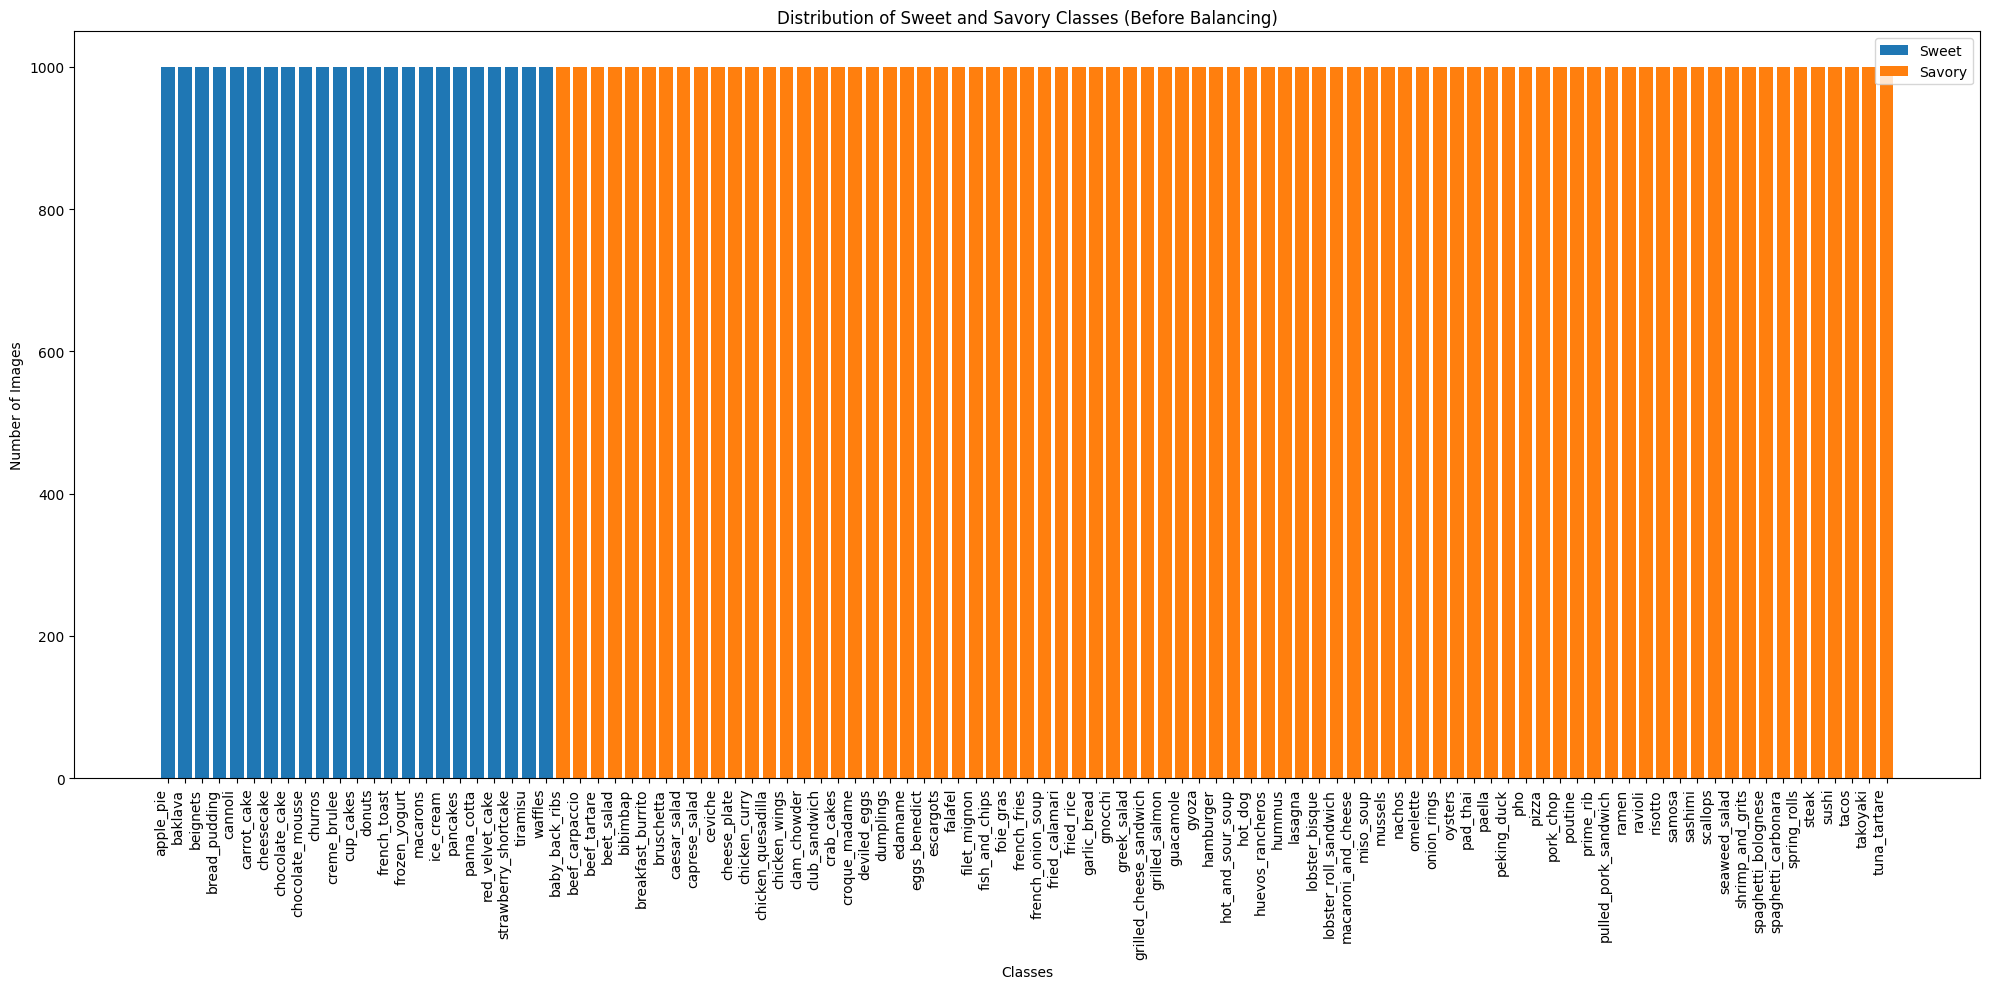

Total number of sweet classes: 23
Total number of savory classes: 78
Total number of sweet images: 23000
Total number of savory images: 78000
Average images per sweet class: 1000.00
Average images per savory class: 1000.00


In [ ]:
# Count the number of images in each sweet and savory class
sweet_counts = {cls: len(os.listdir(os.path.join(dir, cls))) for cls in sweet_classes}
savory_counts = {cls: len(os.listdir(os.path.join(dir, cls))) for cls in savory_classes}

# Create lists for plotting
sweet_labels = list(sweet_counts.keys())
sweet_values = list(sweet_counts.values())
savory_labels = list(savory_counts.keys())
savory_values = list(savory_counts.values())

# Create a bar plot
plt.figure(figsize=(20, 10))

# Plot sweet classes
plt.bar(range(len(sweet_counts)), sweet_values, label='Sweet')

# Plot savory classes
plt.bar(range(len(sweet_counts), len(sweet_counts) + len(savory_counts)), savory_values, label='Savory')

plt.title('Distribution of Sweet and Savory Classes (Before Balancing)')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(range(len(sweet_counts) + len(savory_counts)), sweet_labels + savory_labels, rotation=90, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Total number of sweet classes: {len(sweet_classes)}")
print(f"Total number of savory classes: {len(savory_classes)}")
print(f"Total number of sweet images: {sum(sweet_values)}")
print(f"Total number of savory images: {sum(savory_values)}")
print(f"Average images per sweet class: {sum(sweet_values)/len(sweet_classes):.2f}")
print(f"Average images per savory class: {sum(savory_values)/len(savory_classes):.2f}")

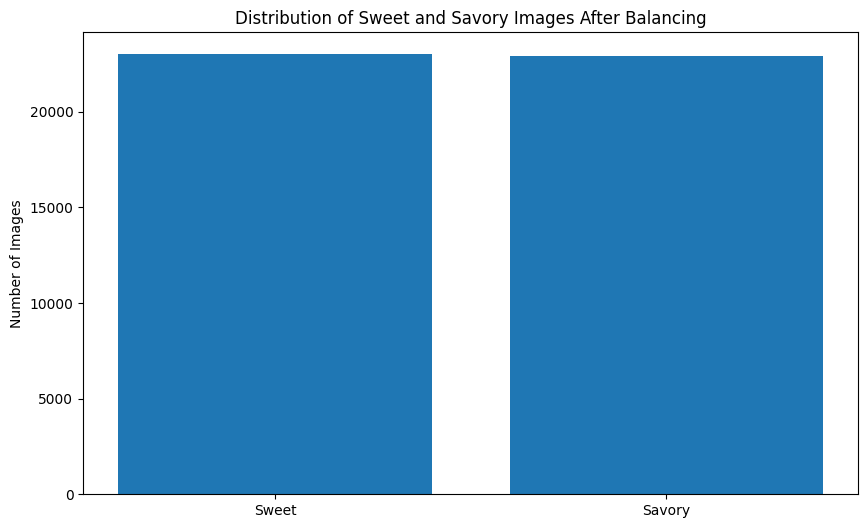

Sweet images: 23000
Savory images: 22932


In [ ]:
import matplotlib.pyplot as plt

# Count the number of images in each category
sweet_count = len(balanced_dataset.sweet_images)
savory_count = len(balanced_dataset.savory_images)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(['Sweet', 'Savory'], [sweet_count, savory_count])
plt.title('Distribution of Sweet and Savory Images After Balancing')
plt.ylabel('Number of Images')
plt.show()

# Print the exact counts
print(f"Sweet images: {sweet_count}")
print(f"Savory images: {savory_count}")


In [ ]:
!pip install tabulate

In [ ]:
from tabulate import tabulate

def calculate_statistics(dataset):
    sweet_pixels = []
    savory_pixels = []

    for img, label in dataset.final_images:
        if label == 1:  # Sweet
            sweet_pixels.extend(img.numpy().flatten())
        else:  # Savory
            savory_pixels.extend(img.numpy().flatten())

    sweet_stats = {
        'Mean': np.mean(sweet_pixels),
        'Median': np.median(sweet_pixels),
        'Std Dev': np.std(sweet_pixels)
    }

    savory_stats = {
        'Mean': np.mean(savory_pixels),
        'Median': np.median(savory_pixels),
        'Std Dev': np.std(savory_pixels)
    }

    return sweet_stats, savory_stats

# Calculate statistics for the entire balanced dataset
sweet_stats, savory_stats = calculate_statistics(balanced_dataset)

# Prepare data for tabulation
data = [
    ["Sweet", sweet_stats['Mean'], sweet_stats['Median'], sweet_stats['Std Dev']],
    ["Savory", savory_stats['Mean'], savory_stats['Median'], savory_stats['Std Dev']]
]

# Create and print the table
headers = ["Category", "Mean", "Median", "Std Dev"]
print(tabulate(data, headers=headers, tablefmt="grid", floatfmt=".4f"))

+------------+--------+----------+-----------+
| Category   |   Mean |   Median |   Std Dev |
+============+========+==========+===========+
| Sweet      | 0.2379 |   0.2348 |    1.2902 |
+------------+--------+----------+-----------+
| Savory     | 0.2380 |   0.2348 |    1.2885 |
+------------+--------+----------+-----------+


In [ ]:
# Labels for the splits
total_size_dataset = len(balanced_dataset)
train_size_plot = int(0.8 * total_size_dataset)
val_size_plot = int(0.1 * total_size_dataset)
test_size_plot = total_size_dataset - train_size_plot - val_size_plot

splits = ['Training', 'Validation', 'Test']
sizes = [train_size_plot, val_size_plot, test_size_plot]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(splits, sizes, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Data Splitting Distribution', fontsize=16)
plt.xlabel('Data Splits', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding data labels on top of the bars
for i, size in enumerate(sizes):
    plt.text(i, size + 50, str(size), ha='center', fontsize=12)

# Show the plot
plt.show()

## Balanced Data Splitting for Train, Val and Test ##
To get equal samples from each class in train, val and test

In [6]:
def balanced_random_split(dataset, train_size, val_size, test_size):
    # Separate sweet and savory images
    sweet_images = dataset.sweet_images
    print(f"{len(sweet_images)} sweeet images")
    savory_images = dataset.savory_images
    print(f"{len(savory_images)} savory images")

    # Shuffle sweet and savory images to ensure random distribution
    random.shuffle(sweet_images)
    random.shuffle(savory_images)

    # Calculate the number of images for each split
    train_sweet = sweet_images[:train_size // 2]
    val_sweet = sweet_images[train_size // 2: (train_size // 2) + (val_size // 2)]
    test_sweet = sweet_images[(train_size // 2) + (val_size // 2):]

    train_savory = savory_images[:train_size // 2]
    val_savory = savory_images[train_size // 2: (train_size // 2) + (val_size // 2)]
    test_savory = savory_images[(train_size // 2) + (val_size // 2):]

    # Combine sweet and savory images in each split
    train_split = train_sweet + train_savory
    val_split = val_sweet + val_savory
    test_split = test_sweet + test_savory

    # Shuffle each split to ensure randomness within each dataset
    random.shuffle(train_split)
    random.shuffle(val_split)
    random.shuffle(test_split)

    return train_split, val_split, test_split

# Define train-validation split
train_size = int(0.8 * len(balanced_dataset))
val_size = int(0.1 * len(balanced_dataset))
test_size = len(balanced_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = balanced_random_split(balanced_dataset, train_size, val_size, test_size)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

23000 sweeet images
22932 savory images


Saving Test dataset\
Only saving 10 images as a test subset

In [ ]:
import os
import random
import shutil
from PIL import Image
from zipfile import ZipFile


# Directory where Food101 images are stored
image_dir = "/content/food101/food-101/images"

# Classes for sweet and savory
sweet_classes = ['apple_pie', 'baklava', 'beignets', 'bread_pudding', 'cannoli']
savory_classes = [cls for cls in os.listdir(image_dir) if cls not in sweet_classes]

# Randomly select 5 sweet and 5 savory images
random.seed(12)
selected_images = []

for cls_list, label in [(sweet_classes, 1), (savory_classes, 0)]:
    for _ in range(5):
        class_name = random.choice(cls_list)
        class_dir = os.path.join(image_dir, class_name)
        image_name = random.choice(os.listdir(class_dir))
        image_path = os.path.join(class_dir, image_name)
        selected_images.append((image_path, label))

# Save selected images to a temporary directory
os.makedirs("test_images", exist_ok=True)
labels = []

for idx, (img_path, label) in enumerate(selected_images):
    img = Image.open(img_path)
    img_save_path = os.path.join("test_images", f"img_{idx}.jpg")
    img.save(img_save_path)
    labels.append((f"img_{idx}.jpg", label))

# Save labels as a text file
with open("test_images/labels.txt", "w") as f:
    for img_name, label in labels:
        f.write(f"{img_name},{label}\n")

# Zip the selected images directory
with ZipFile("test_images.zip", "w") as zipf:
    for root, _, files in os.walk("test_images"):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

# Download the zip file
from google.colab import files
files.download("test_images.zip")


## ResNet50 ##

In [ ]:
import torch.nn as nn
from torchvision import models

# Load a pretrained model (e.g., ResNet18)
#weights = ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights="IMAGENET1K_V1")

# Modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Single output node for binary classification
    nn.Sigmoid()  # Sigmoid activation for binary output
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.2MB/s]


In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    # Initialize lists to store loss and accuracy values
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_accuracy = 0.0
    best_model_wts = None

    model.train()
    for epoch in range(epochs):
        print(f"Training epoch {epoch + 1}/{epochs}:")
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation step
        val_loss, val_acc = validate_model(model, val_loader, criterion)

        # Store the metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_wts = model.state_dict()  # Save the current best model weights

    # After training, load the best model weights
    model.load_state_dict(best_model_wts)

    # Plotting the loss and accuracy curves
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images).squeeze()

            # Calculate loss and accuracy
            val_loss += criterion(outputs, labels).item()
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss / len(val_loader), correct / total

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plotting loss curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Training epoch 1/5:
Epoch 1/5, Loss: 0.3291, Train Accuracy: 0.8573, Val Loss: 0.2341, Val Accuracy: 0.9072
Training epoch 2/5:
Epoch 2/5, Loss: 0.1778, Train Accuracy: 0.9301, Val Loss: 0.2399, Val Accuracy: 0.9014
Training epoch 3/5:
Epoch 3/5, Loss: 0.0920, Train Accuracy: 0.9666, Val Loss: 0.3301, Val Accuracy: 0.8881
Training epoch 4/5:
Epoch 4/5, Loss: 0.0399, Train Accuracy: 0.9864, Val Loss: 0.3070, Val Accuracy: 0.9090
Training epoch 5/5:
Epoch 5/5, Loss: 0.0222, Train Accuracy: 0.9925, Val Loss: 0.3476, Val Accuracy: 0.9109


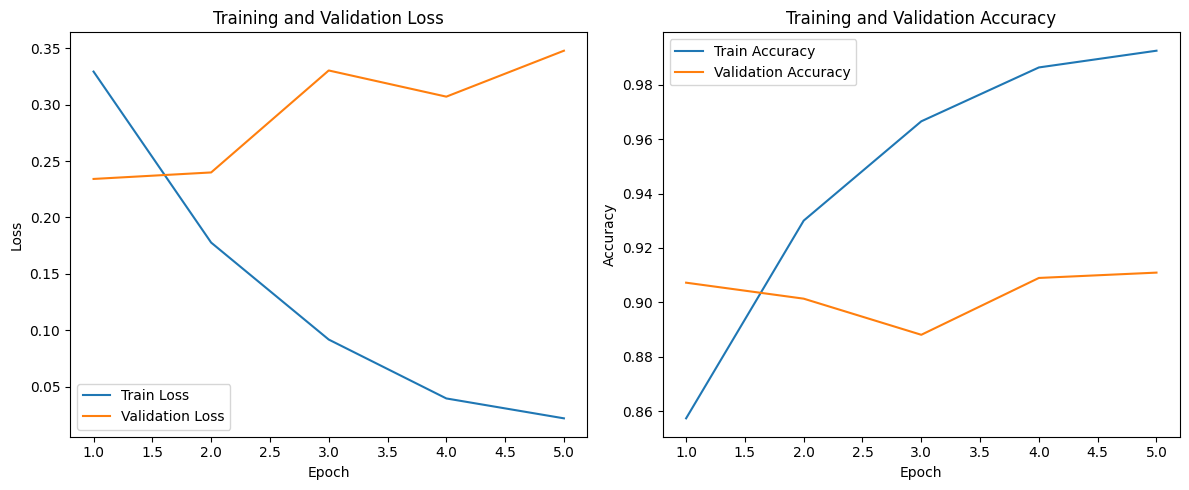

In [ ]:
# Train the model
EPOCHS = 5
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

### Testing ###

In [ ]:
test_loss, test_acc = validate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
model_name = f"Sweet_Vs_Savory_46000_noAugment_batch{BATCH_SIZE}_1e_5.pth"
torch.save(model.state_dict(), model_name)
# # Load the test dataset
# test_dataset = torch.load("test_dataset.pth")
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# Load the test dataset from the file
# with open("test_dataset.pkl", "rb") as f:
#     test_dataset = pickle.load(f)

# print("Test dataset loaded successfully")

Test Loss: 0.3731, Test Accuracy: 0.9032


<ipython-input-5-04b43c3c8148>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/Sweet_Vs_Savory_46000_noAugment_batch64.pth", map

Test Loss: 0.8466, Test Accuracy: 0.9000


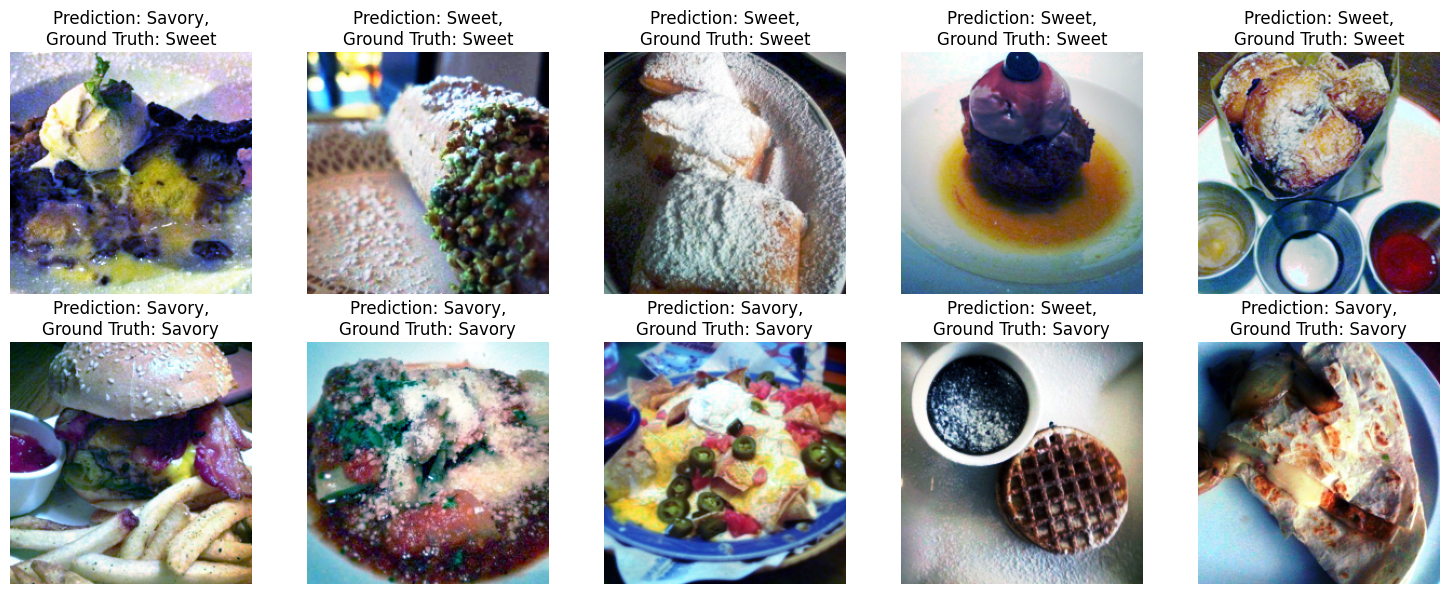

In [5]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from PIL import Image
import os
from torchvision import models
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),           # Center crop to 224x224
    HistogramEqualization(),  # Custom histogram equalization transform
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # From ImageNet
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load a pretrained model (e.g., ResNet18)
#weights = ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights="IMAGENET1K_V1")

# Modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Single output node for binary classification
    nn.Sigmoid()  # Sigmoid activation for binary output
)
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model.load_state_dict(torch.load("/content/Sweet_Vs_Savory_46000_noAugment_batch64.pth", map_location=device))

model = model.to(device)

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images).squeeze()

            # Calculate loss and accuracy
            val_loss += criterion(outputs, labels).item()
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss / len(val_loader), correct / total

# Define a custom dataset for the test images
class TestDataset(Dataset):
    def __init__(self, img_dir, label_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(label_file, "r") as f:
            self.labels = [line.strip().split(",") for line in f]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name, label = self.labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, int(label)

# Path to the unzipped folder and labels
zip_file_name = "test_images.zip"
output_dir = "test_images_unzipped"
with ZipFile(zip_file_name, "r") as zipf:
    zipf.extractall(output_dir)
unzipped_folder = f"{output_dir}/"
label_file = os.path.join(unzipped_folder, "labels.txt")

# Use your custom transforms
test_dataset = TestDataset(img_dir=unzipped_folder, label_file=label_file, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Run validation
test_loss, test_acc = validate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

def display_predictions_grid(model, loader, transform=None, rows=2, cols=5):
    model.eval()  # Ensure the model is in evaluation mode
    class_names = ["Savory", "Sweet"]  # Class labels

    # Set up the plot grid
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()  # Flatten the axes for easy indexing

    img_count = 0  # Counter for how many images we've displayed

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(images).squeeze()
            preds = (outputs >= 0.5).float()  # Apply threshold of 0.5 for binary classification

            # Move data to CPU for visualization
            images = images.cpu()
            preds = preds.cpu()
            labels = labels.cpu()

            for i in range(len(images)):
                if img_count >= rows * cols:  # Stop once we've filled the grid
                    break

                img = images[i].permute(1, 2, 0).numpy()  # Convert from CHW to HWC for plotting
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize (reverse normalization)
                img = img.clip(0, 1)  # Ensure values are in range [0, 1]

                # Display the image in the grid
                axes[img_count].imshow(img)
                axes[img_count].set_title(
                    f"Prediction: {class_names[int(preds[i])]},\nGround Truth: {class_names[int(labels[i])]}"
                )
                axes[img_count].axis("off")
                img_count += 1

            if img_count >= rows * cols:  # Stop once we've filled the grid
                break

    plt.tight_layout()
    plt.show()

# Call the function to display predictions as a grid
display_predictions_grid(model, test_loader, rows=2, cols=5)


### Evaluation Metrics ###

<ipython-input-29-fb0fb4c48a6c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Precision: 0.8976
Recall: 0.9134
F1 Score: 0.9054
ROC AUC: 0.9699
PRC AUC: 0.9719


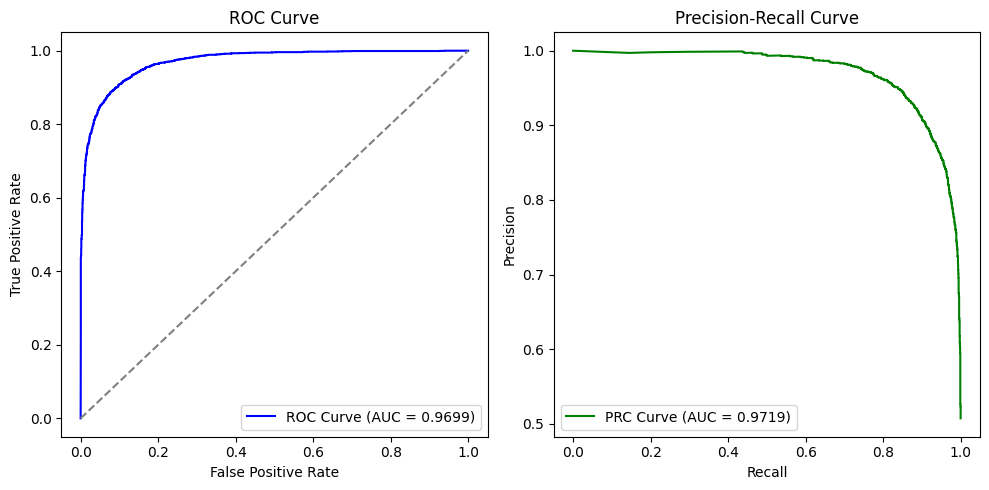

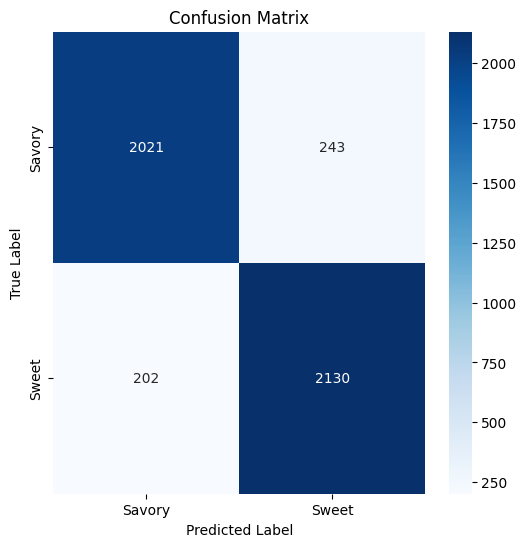

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns

def evaluation_metrics(model_path, model, test_loader, device):
    # Load the saved model weights
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    # Iterate through the test loader to get predictions and true labels
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images).squeeze()
            preds = (outputs >= 0.5).float()  # Binary threshold at 0.5

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate Precision, Recall, F1 Score
    binary_preds = (all_preds >= 0.5).astype(int)
    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds)

    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Compute PRC Curve
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_preds)
    prc_auc = auc(recall_curve, precision_curve)

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, binary_preds)

    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PRC AUC: {prc_auc:.4f}")

    # Plot ROC Curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Plot PRC Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_curve, precision_curve, color='green', label=f"PRC Curve (AUC = {prc_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Savory', 'Sweet'], yticklabels=['Savory', 'Sweet'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
model_path = "/content/Sweet_Vs_Savory_46000_noAugment_batch64.pth"
evaluation_metrics(model_path, model, test_loader, device)


### LIME ###

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=266c9d4df155a9236d763b1e011522eb04610526c04a59274006cbe12592bc58
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

def lime_image_explain(test_image_path, label):
    image = Image.open(test_image_path).convert("RGB")

    # Initialize LIME explainer
    explainer = LimeImageExplainer()

    # Explain the image
    explanation = explainer.explain_instance(
        np.array(image),
        predict_function,  # Your model's prediction function
        top_labels=2,  # Number of labels to explain
        hide_color=0,  # Color to use for hidden superpixels
        num_samples=1000  # Number of perturbations
    )

    # Visualize the explanation
    from skimage.color import label2rgb

    # Choose a label to explain (e.g., class 1 for "Sweet")
    label_to_explain = label
    temp, mask = explanation.get_image_and_mask(
        label=label_to_explain,
        positive_only=True,  # Show only positive contributions
        num_features=10,  # Number of superpixels to show
        hide_rest=False  # Show the entire image
    )

    # Display the explanation
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp / 255.0, mask))  # Normalize image values
    plt.title(f"LIME Explanation for Label {label_to_explain}")
    plt.axis("off")
    plt.show()

def preprocess_image(image, transform):
    """Preprocess a single image for the model."""
    image = transform(image)  # Apply the transformations used during training
    if image.shape[0] != 3:  # Ensure the image has 3 channels
        raise ValueError(f"Expected 3 channels, but got {image.shape[0]} channels.")
    return image

def predict_function(images):
    """
    LIME-compatible prediction function.
    Takes a list of images (numpy arrays), preprocesses them,
    and returns class probabilities.
    """
    # Load the model weights
    model.load_state_dict(torch.load("/content/Sweet_Vs_Savory_46000_noAugment_batch64.pth", weights_only=True))
    model.eval()

    # Preprocess and stack images
    inputs = torch.cat(
        [preprocess_image(Image.fromarray(img), data_transforms).unsqueeze(0) for img in images]
    ).to(device)

    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()

    if len(probs.shape) == 1:
        probs = np.expand_dims(probs, axis=1)
    return np.hstack([1 - probs, probs])  # Binary class probabilities

  0%|          | 0/1000 [00:00<?, ?it/s]

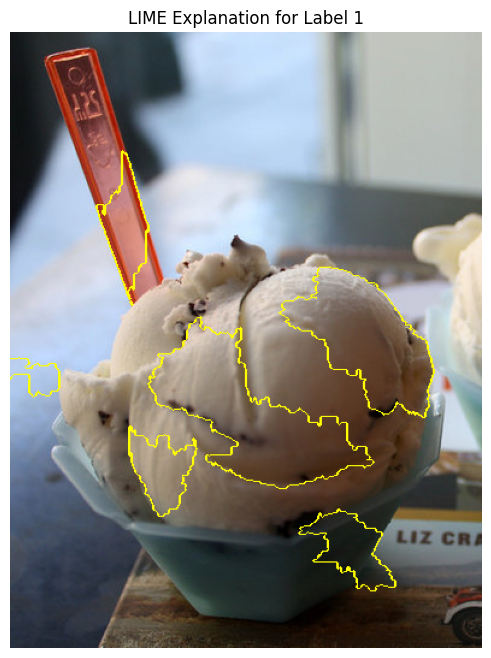

  0%|          | 0/1000 [00:00<?, ?it/s]

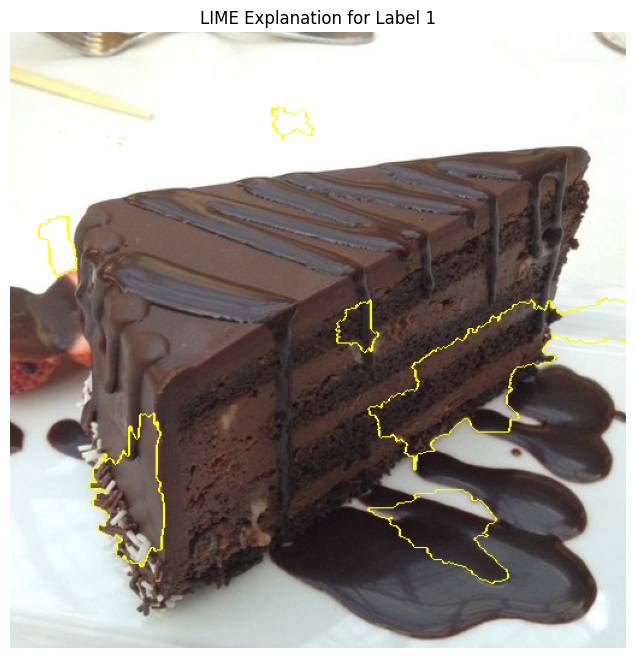

In [ ]:
# Load an image to explain
test_image_path = "/content/food101/food-101/images/ice_cream/418321.jpg"
lime_image_explain(test_image_path, 1)

test_image_path = "/content/food101/food-101/images/chocolate_cake/1520283.jpg"
lime_image_explain(test_image_path, 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

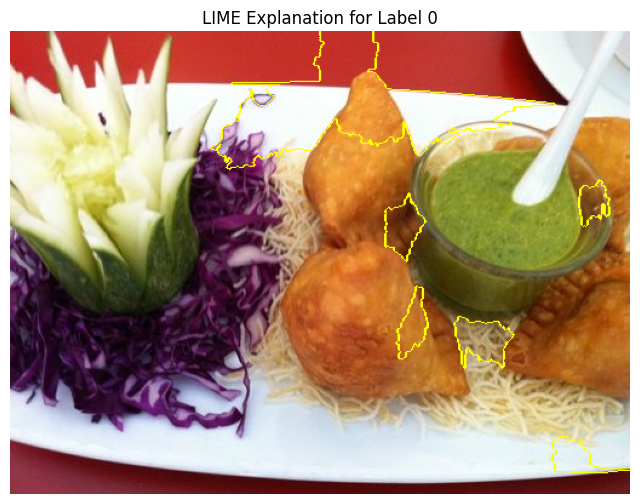

  0%|          | 0/1000 [00:00<?, ?it/s]

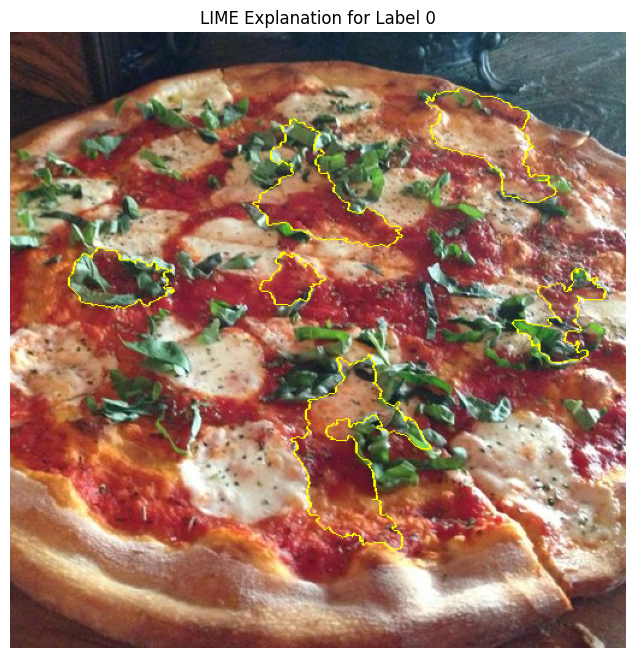

In [ ]:
test_image_path = "/content/food101/food-101/images/samosa/247636.jpg"
lime_image_explain(test_image_path, 0)

test_image_path = "/content/food101/food-101/images/pizza/3770514.jpg"
lime_image_explain(test_image_path, 0)

## VGG + Kbest + PCA + Logistic Regression ##

### VGG ###

In [ ]:
################# VGG Feature Extraction
from torchvision import models
from torch import nn

# Load the pretrained VGG model
vgg = models.vgg16(weights='IMAGENET1K_V1')

# Remove the classification head
vgg_features = vgg.features.to(device)

# Move to the same device
vgg = vgg.to(device)
vgg.eval()  # Set to evaluation mode

def extract_features(dataloader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            # Forward pass to get features
            feats = model(images)
            # Flatten features for compatibility
            feats = feats.view(feats.size(0), -1)
            features.append(feats.cpu())
            labels.append(lbls.cpu())
    return torch.cat(features), torch.cat(labels)

# Extract features from the train, validation, and test sets
train_features, train_labels = extract_features(train_loader, vgg_features, device)
val_features, val_labels = extract_features(val_loader, vgg_features, device)
test_features, test_labels = extract_features(test_loader, vgg_features, device)

# Convert labels to NumPy arrays
train_labels = train_labels.numpy()
val_labels = val_labels.numpy()
test_labels = test_labels.numpy()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.3MB/s]
Extracting features: 100%|██████████| 63/63 [00:21<00:00,  2.98it/s]


### K Best ###

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
# Perform Feature Selection
selector = SelectKBest(f_classif, k=500)
train_selected_features = selector.fit_transform(train_features, train_labels)

# Transform validation and test sets using the selector fitted on the training data
val_selected_features = selector.transform(val_features)
test_selected_features = selector.transform(test_features)


### PCA ###

In [ ]:
from sklearn.decomposition import PCA
# Optional: Use PCA for dimensionality reduction
pca = PCA(n_components=100)
train_pca_features = pca.fit_transform(train_selected_features)
# Transform validation and test sets using the fitted PCA
val_pca_features = pca.transform(val_selected_features)
test_pca_features = pca.transform(test_selected_features)

print(f"Train features shape: {train_pca_features.shape}")
print(f"Validation features shape: {val_pca_features.shape}")
print(f"Test features shape: {test_pca_features.shape}")

Train features shape: (31964, 100)
Validation features shape: (3994, 100)
Test features shape: (3997, 100)


### Data Statistics ###

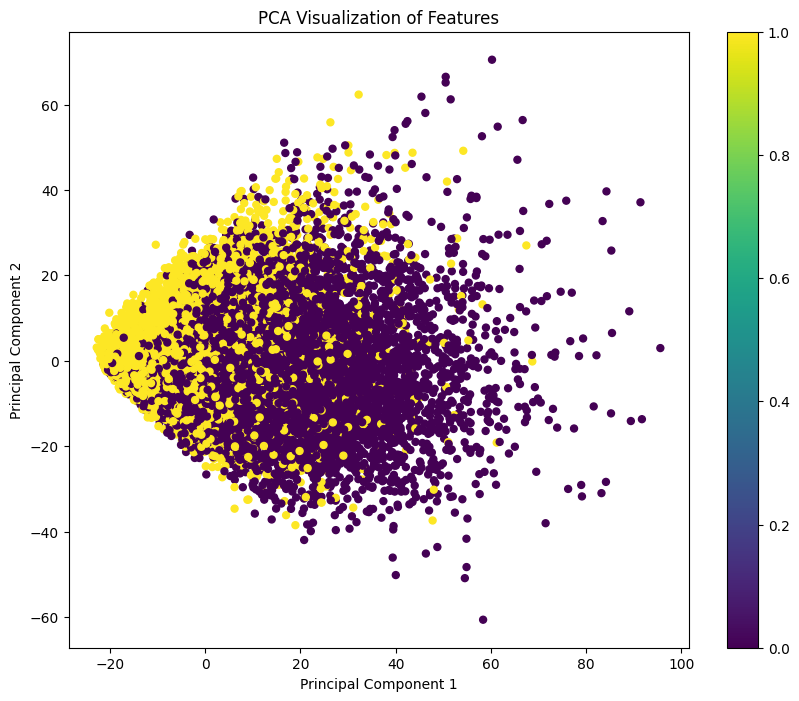

In [ ]:
import matplotlib.pyplot as plt

# Dimensionality Reduction (Optional): PCA Visualization
def visualize_pca_diff(reduced_features, labels):
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', s=25)
    plt.xlabel(f'Principal Component 1')
    plt.ylabel(f'Principal Component 2')
    plt.colorbar()
    plt.title("PCA Visualization of Features")
    plt.show()

# Visualize train features
visualize_pca_diff(train_pca_features, train_labels)

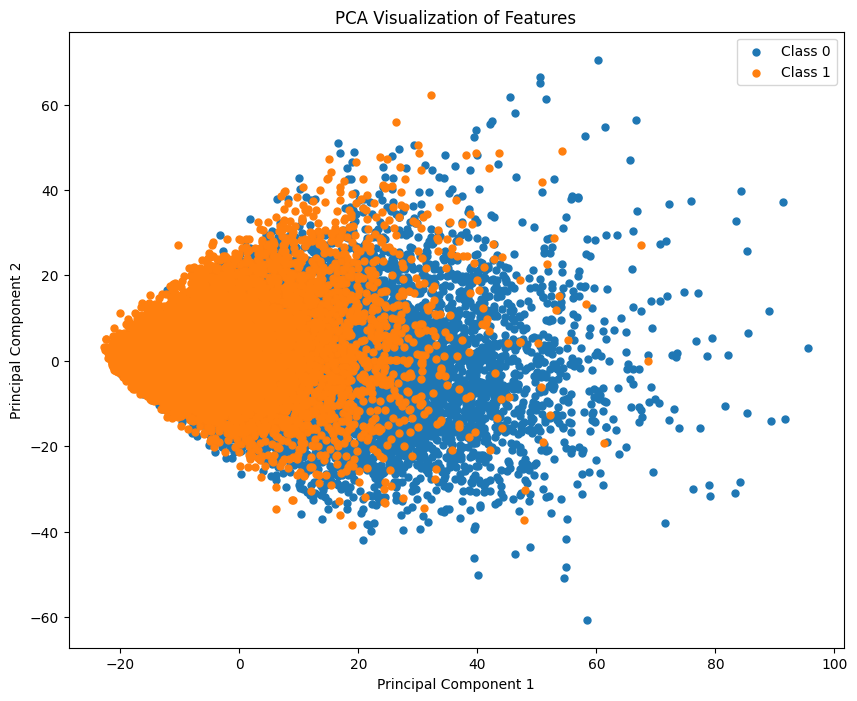

In [ ]:
import matplotlib.pyplot as plt

def visualize_pca_diff(reduced_features, labels):
    plt.figure(figsize=(10, 8))

    # Create a scatter plot for each unique label
    unique_labels = set(labels)
    for label in unique_labels:
        mask = labels == label
        plt.scatter(reduced_features[mask, 0], reduced_features[mask, 1],
                    label=f'Class {label}', s=25)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("PCA Visualization of Features")
    plt.legend()
    plt.show()

# Visualize train features
visualize_pca_diff(train_pca_features, train_labels)

In [ ]:
import plotly.express as px

print(np.unique(train_labels))

fig = px.scatter(x=train_pca_features[:, 0], y=train_pca_features[:, 1], color=train_labels)
fig.update_layout(
    title="PCA visualization of Custom Classification dataset",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
)
fig.show()

[0 1]


In [ ]:
import plotly.express as px

fig = px.scatter(
    x=train_pca_features[:, 0],
    y=train_pca_features[:, 1],
    color=train_labels,
    labels={
        'color': 'Class',
        'x': "First Principal Component",
        'y': "Second Principal Component"
    },
    title="PCA visualization of Custom Classification dataset"
)

fig.update_layout(
    showlegend=True,
    legend_title="Class"
)

fig.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(train_selected_features)
tsne.kl_divergence_

4.638062477111816

In [ ]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=train_labels)
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

### Logistic Regression ###

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize Logistic Regression model
logistic_model = LogisticRegression(max_iter=5000)  # Increase max_iter if needed

# Fit the model on the training data
logistic_model.fit(train_pca_features, train_labels)

# Predict on the test data
test_predictions = logistic_model.predict(test_pca_features)

# Calculate the classification accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Classification Accuracy: {accuracy:.2f}")

Classification Accuracy: 0.77
